# Deeper CNN Model Optimization

This notebook focuses on optimizing the Deeper CNN model which was identified as the best-performing custom architecture in our model comparison study (86.67% test accuracy). Through systematic optimization of the architecture, training strategies, and data augmentation, we aim to close the gap with the ResNet-18 baseline (99.33% test accuracy).

## Overview and Objectives

In this notebook, we will:

1. **Analyze strengths and weaknesses** of our current Deeper CNN model
2. **Implement architectural improvements** including selective attention and residual connections
3. **Optimize training strategies** using mixed precision, gradient clipping, and advanced learning rate scheduling
4. **Enhance data augmentation** with class-specific transformations
5. **Evaluate performance** against both our original model and the ResNet-18 baseline

By systematically applying these optimizations, we aim to develop a more efficient and accurate model while maintaining the advantages of a custom CNN architecture specifically designed for musical instrument classification.

In [2]:
# Essential imports for enhanced model architecture
import os
import sys
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import time
from tqdm import tqdm
import json

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from PIL import Image
from torch.nn import Dropout2d
import torch.nn.functional as F

# Check if we're running in Google Colab
import importlib.util
IN_COLAB = importlib.util.find_spec("google.colab") is not None

# Get the current directory
current_dir = os.getcwd()
print(f"Current directory: {current_dir}")

if IN_COLAB:
    # Add project root to path to ensure imports work correctly
    project_root = os.path.join(current_dir, "MIC-MA1")
    sys.path.insert(0, project_root)
    print(f"Project root added to path: {project_root}")
else:
    # Running locally
    project_root = str(Path(current_dir).parent)
    sys.path.append(project_root)
    print(f"Running locally, project root: {project_root}")
    print("💻 Running locally - using local environment")

# Import from our project modules
from src.data.dataset import InstrumentDataset, get_transforms
from src.data.preprocessing import create_train_val_split
from src.models.custom_cnn import MusicInstrumentCNN, create_custom_cnn
from src.training.trainer import train_model, evaluate_model
from src.training.scheduler import get_scheduler
from src.data.augmentation import AdvancedAugmentation
from src.models.enhanced_cnn import create_enhanced_flexible_cnn, EnhancedFlexibleCNN
from src.training.enhanced_trainer import train_model_with_clipping
from src.visualization.plotting import plot_training_history, plot_confusion_matrix

# Check for Colab-specific scripts
try:
    from scripts.colab_integration import setup_colab_environment, check_gpu

    if IN_COLAB:
        print("🚀 Running in Google Colab - setting up environment...")
        setup_colab_environment()  # This handles all the Colab-specific setup

        # Check GPU availability
        device = check_gpu()
        print(f"Using device: {device}")
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {device}")
except ImportError:
    print("Colab integration module not found, using default device setup")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

# Set random seed for reproducibility
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Function to load configuration
def load_config(config_path):
    with open(config_path, 'r') as file:
        config = yaml.safe_load(file)
    return config

Current directory: /content
Project root added to path: /content/MIC-MA1
🚀 Running in Google Colab - setting up environment...
Setting up Colab environment for Musical Instrument Classification...
Running in Google Colab environment
Installing dependencies...
Environment setup complete!
Using device: cuda
GPU available: Tesla T4
Memory allocated: 0.00 GB
Memory cached: 0.00 GB
Using device: cuda


## 1. Load and Analyze the Deeper CNN Configuration

We'll start with the Deeper CNN configuration that achieved 86.67% test accuracy in our model comparison, and then systematically apply optimizations to improve its performance.

### Why Configuration Analysis Matters

Understanding the existing architecture's configuration is crucial before applying improvements. Our Deeper CNN performed well among custom models but still has a significant gap compared to the ResNet-18 baseline. By carefully analyzing its strengths and limitations, we can identify specific areas for improvement:

- **Network depth and width**: Are there bottlenecks in information flow?
- **Regularization strategy**: Is the current dropout approach optimal?
- **Training dynamics**: Does the model converge properly or suffer from gradient issues?

This analysis will guide our systematic approach to optimization.

In [3]:
# Load configurations from YAML files
if IN_COLAB:
    deeper_config_path = os.path.join(project_root, "config", "custom_cnn_deeper.yaml")
    opt_config_path = os.path.join(project_root, "config", "optimized_deeper_cnn.yaml")
else:
    deeper_config_path = os.path.join(project_root, "config", "custom_cnn_deeper.yaml")
    opt_config_path = os.path.join(project_root, "config", "optimized_deeper_cnn.yaml")

deeper_config = load_config(deeper_config_path)
opt_config = load_config(opt_config_path)

# Display the original deeper CNN configuration
print("Original Deeper CNN Configuration:")
for key, value in deeper_config.items():
    print(f"{key}: {value}")

# Create a base configuration for our optimization experiments
config = deeper_config.copy()

# Initial optimization adjustments
config['training']['num_epochs'] = 100  # Increased to allow for more thorough training
config['training']['optimizer'] = {
    'name': 'adamw',
    'learning_rate': 0.0005,  # Reduced from 0.001 for better stability
    'weight_decay': 0.0005,  # Kept at 0.0005 which was working well before
    'beta1': 0.9,
    'beta2': 0.999
}

# Display the initial optimization changes
print("\nInitial Optimization Changes:")
print(f"- Increased epochs from 30 to {config['training']['num_epochs']}")
print(f"- Adjusted learning rate to {config['training']['optimizer']['learning_rate']}")
print(f"- Using weight decay of {config['training']['optimizer']['weight_decay']}")

Original Deeper CNN Configuration:
model: {'architecture': 'flexible_cnn', 'input_channels': 3, 'num_classes': 30, 'conv_layers': [32, 64, 128, 256, 512, 512], 'fc_layers': [512, 256], 'kernel_size': 3, 'pool_size': 2, 'dropout': [0.1, 0.2, 0.3, 0.4, 0.5, 0.5, 0.5], 'activation': 'relu', 'pooling_type': 'max', 'use_batch_norm': True}
training: {'num_epochs': 30, 'batch_size': 32, 'loss_function': 'cross_entropy', 'optimizer': {'name': 'adamw', 'learning_rate': 0.001, 'weight_decay': 0.0005, 'momentum': 0.9, 'nesterov': True, 'beta1': 0.9, 'beta2': 0.999}, 'scheduler': {'name': 'onecycle', 'max_lr': 0.01, 'step_size': 7, 'gamma': 0.1, 'patience': 3, 'factor': 0.1, 't_max': 30, 'use_warmup': True, 'warmup_epochs': 3}}
data: {'img_size': 224, 'data_dir': 'data\\raw\\30_Musical_Instruments\\', 'num_workers': 4, 'pin_memory': True, 'train_val_split': 0.8, 'use_weighted_sampler': False}
augmentation: {'use_augmentation': True, 'augmentation_strength': 'medium', 'use_mixup': False, 'mixup_alp

## 2. Data Preparation with Enhanced Augmentation

We'll implement stronger data augmentation strategies to improve the model's generalization. A well-designed augmentation strategy can help the model learn more robust features.

### The Importance of Augmentation in Limited Data Scenarios

Musical instrument classification presents unique challenges due to varying instrument orientations, lighting conditions, and partial occlusions. Proper augmentation helps the model generalize from limited training examples by:

1. **Increasing effective dataset size** through artificial variations
2. **Reducing overfitting** by preventing memorization of training examples
3. **Improving robustness** to real-world variations in instrument appearance

We'll use a carefully calibrated approach with moderate augmentation strength to avoid introducing artifacts while maximizing generalization.

In [4]:
# Set data paths
if IN_COLAB:
    # Adjust path based on your Google Drive structure
    data_dir = os.path.join(project_root, "data/raw/30_Musical_Instruments")
    if not os.path.exists(data_dir):
        print("⚠️ Dataset not found in the expected location")
        print("Please upload the dataset to the correct location in Google Drive")
else:
    # Use string paths for consistency rather than Path objects
    data_dir = os.path.join(project_root, "data", "raw", "30_Musical_Instruments")

# Check if the data directory exists
if not os.path.exists(data_dir):
    raise FileNotFoundError(f"Data directory not found: {data_dir}")

print(f"Using data directory: {data_dir}")

# The dataset is already split into train/valid/test
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "valid")
test_dir = os.path.join(data_dir, "test")

# Make sure the expected structure exists
if not all(os.path.exists(d) for d in [train_dir, val_dir, test_dir]):
    raise FileNotFoundError(f"Expected train/valid/test subdirectories not found in {data_dir}")

# Get class names (subdirectory names) from the train directory
classes = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]
classes.sort()  # Sort alphabetically for consistency

# Import glob for file pattern matching
import glob

# Get file paths for each split
train_files = []
val_files = []

for class_name in classes:
    # Get training files
    class_train_dir = os.path.join(train_dir, class_name)
    for img_path in glob.glob(os.path.join(class_train_dir, '*.*')):
        # Filter image files
        if any(img_path.lower().endswith(ext) for ext in ['.jpg', '.jpeg', '.png', '.bmp']):
            train_files.append(img_path)

    # Get validation files
    class_val_dir = os.path.join(val_dir, class_name)
    for img_path in glob.glob(os.path.join(class_val_dir, '*.*')):
        # Filter image files
        if any(img_path.lower().endswith(ext) for ext in ['.jpg', '.jpeg', '.png', '.bmp']):
            val_files.append(img_path)

# Verify that files were found
if len(train_files) == 0 or len(val_files) == 0:
    raise ValueError("No files found for training/validation. Check the dataset structure and path.")

print(f"Number of classes: {len(classes)}")
print(f"Number of training samples: {len(train_files)}")
print(f"Number of validation samples: {len(val_files)}")

# Set up data augmentation - using medium strength to avoid too aggressive transformations
# This was 'strong' in previous implementation which might have been too aggressive
augmentation_strength = 'medium'
img_size = config.get('data', {}).get('img_size', 224)

print(f"\nUsing {augmentation_strength} augmentation strategy")

# Get transforms from our enhanced augmentation module
transforms_dict = AdvancedAugmentation.get_advanced_transforms(
    img_size=img_size,
    augmentation_strength=augmentation_strength
)

train_transform = transforms_dict['train']
val_transform = transforms_dict['val']

# Create datasets
train_dataset = InstrumentDataset(train_files, classes, transform=train_transform)
val_dataset = InstrumentDataset(val_files, classes, transform=val_transform)

# Create data loaders
batch_size = config.get('training', {}).get('batch_size', 32)
num_workers = config.get('data', {}).get('num_workers', 4)

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)

# Create a dictionary of dataloaders for the trainer
dataloaders = {
    'train': train_loader,
    'val': val_loader
}

Using data directory: /content/MIC-MA1/data/raw/30_Musical_Instruments
Number of classes: 30
Number of training samples: 4793
Number of validation samples: 150

Using medium augmentation strategy


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


## 3. Class-Specific Augmentation Strategy

We'll implement class-specific augmentation to provide additional transformations for challenging instrument classes that had lower accuracy in our previous experiments.

### Why Class-Specific Augmentation Matters

Our previous analysis revealed that certain instrument classes consistently underperform, such as wind instruments (Flute, Clarinet) and stringed instruments with complex shapes (Sitar). These classes often share characteristics that make them challenging to classify:

- **Similar visual appearances** (long, cylindrical shapes for wind instruments)
- **Variable orientations** during performance (held horizontally or vertically)
- **Complex details** that distinguish between similar instruments

By applying tailored augmentation strategies to these challenging classes, we can help the model learn more discriminative features specific to each instrument type. This targeted approach is more effective than applying stronger augmentation uniformly across all classes.

In [5]:
import torchvision.transforms as transforms
from torch.utils.data import Dataset

# Define a class-specific transform that applies different transformations based on class
class ClassSpecificTransform:
    def __init__(self, base_transform, special_classes, special_transform):
        self.base_transform = base_transform
        self.special_classes = special_classes
        self.special_transform = special_transform

    def __call__(self, img, class_name):
        if class_name in self.special_classes:
            return self.special_transform(img)
        return self.base_transform(img)

# List of challenging instrument classes based on previous confusion matrices
challenging_classes = ['Didgeridoo', 'Flute', 'Trombone', 'Sitar', 'Alphorn',
                      'Clarinet', 'Piano', 'Steel drum', 'Castanets', 'Maracas']

# Create a proper transform pipeline for challenging classes
stronger_transform = transforms.Compose([
    # Spatial transformations
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Less aggressive crop
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),  # Less rotation

    # Color transformations - reduced intensity
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),

    # Convert to tensor and normalize
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Enhanced dataset class that handles class-specific augmentation properly
class EnhancedInstrumentDataset(Dataset):
    def __init__(self, image_paths, classes, transform=None, challenging_classes=None, stronger_transform=None):
        self.image_paths = image_paths
        self.classes = {class_name: idx for idx, class_name in enumerate(classes)}
        self.transform = transform
        self.challenging_classes = challenging_classes or []
        self.stronger_transform = stronger_transform

        # Extract labels from image paths
        self.labels = []
        for path in image_paths:
            # Extract class name from directory path
            class_name = os.path.basename(os.path.dirname(path))
            self.labels.append(self.classes[class_name])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        # Extract class name from path
        class_name = os.path.basename(os.path.dirname(img_path))

        # Apply appropriate transform based on class
        if class_name in self.challenging_classes and self.stronger_transform is not None:
            image = self.stronger_transform(image)
        elif self.transform:
            image = self.transform(image)

        return image, label

    # Method to get original image for visualization
    def get_original(self, idx):
        img_path = self.image_paths[idx]
        return Image.open(img_path).convert('RGB')

# Create enhanced datasets with class-specific augmentation
enhanced_train_dataset = EnhancedInstrumentDataset(
    train_files,
    classes,
    transform=train_transform,
    challenging_classes=challenging_classes,
    stronger_transform=stronger_transform
)

enhanced_train_loader = DataLoader(
    enhanced_train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True
)

# Update our dataloaders dictionary with the enhanced train loader
dataloaders['train'] = enhanced_train_loader

print(f"Enhanced training with class-specific augmentation for {len(challenging_classes)} challenging classes")

Enhanced training with class-specific augmentation for 10 challenging classes


## 4. Visualize Augmented Images

Let's visualize some examples of our augmented training images to ensure our augmentation strategy preserves the key features of musical instruments while providing enough variety for the model to learn robust representations.

### The Value of Augmentation Visualization

Visualizing augmented images serves multiple important purposes:

1. **Quality control**: Ensuring transformations preserve key instrument features
2. **Augmentation debugging**: Identifying potential issues in the transformation pipeline
3. **Strategy validation**: Confirming that class-specific augmentations are appropriate
4. **Documentation**: Providing visual evidence of the techniques applied

Particularly for musical instruments, we need to ensure that augmentations don't distort the distinctive shapes and features that differentiate instrument classes. By inspecting augmented examples before training, we can adjust parameters if needed.

Visualizing augmentations with a focus on challenging instrument classes:


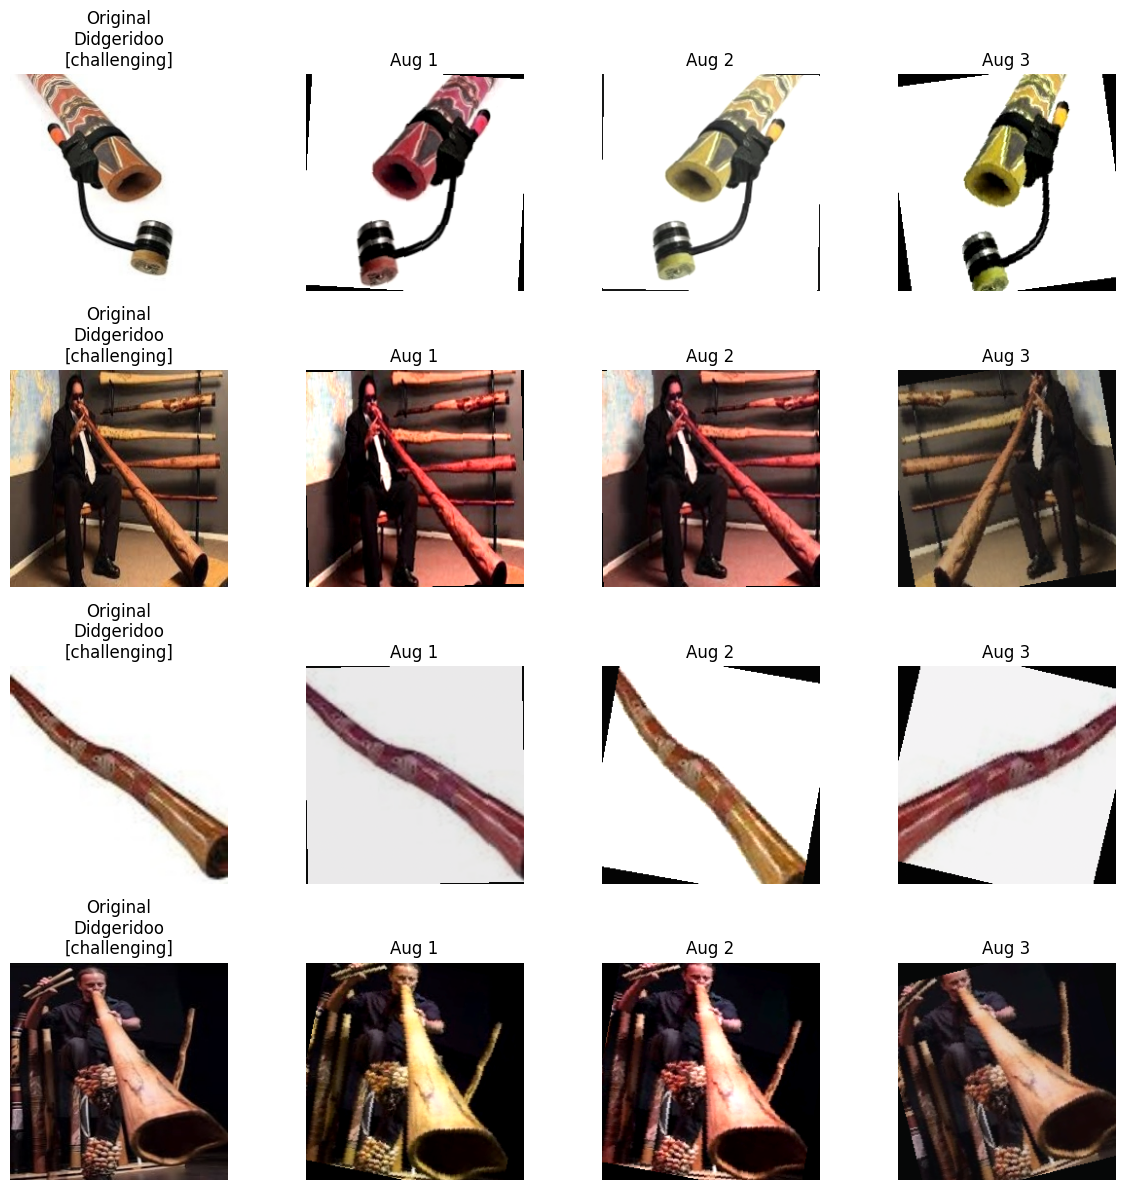

In [6]:
# Add method to get original (non-augmented) images
def get_original(self, idx):
    """
    Get the original image without any transformations

    Args:
        idx (int): Index of the image

    Returns:
        PIL.Image: The original image
    """
    img_path = self.image_paths[idx]
    return Image.open(img_path).convert('RGB')

# Attach the method to our enhanced dataset class
EnhancedInstrumentDataset.get_original = get_original

# Function to visualize augmentations
def visualize_augmentations(dataset, num_samples=4, num_augmentations=3, focus_on_challenging=True):
    """
    Visualize the effect of data augmentations on samples from the dataset

    Args:
        dataset: The dataset with augmentations applied
        num_samples: Number of different samples to visualize
        num_augmentations: Number of augmentations to apply to each sample
        focus_on_challenging: Whether to focus on challenging classes
    """
    # Get indices of challenging classes if requested
    indices = []
    if focus_on_challenging and hasattr(dataset, 'challenging_classes'):
        challenging_indices = []
        for idx in range(len(dataset)):
            img_path = dataset.image_paths[idx]
            class_name = os.path.basename(os.path.dirname(img_path))
            if class_name in dataset.challenging_classes:
                challenging_indices.append(idx)
        # Sample from challenging classes if we have enough
        if len(challenging_indices) >= num_samples:
            indices = np.random.choice(challenging_indices, num_samples, replace=False)
        else:
            # Otherwise sample randomly and prioritize challenging classes
            indices = challenging_indices[:min(len(challenging_indices), num_samples)]
            if len(indices) < num_samples:
                regular_indices = [i for i in range(len(dataset)) if i not in challenging_indices]
                indices = np.concatenate([indices,
                                        np.random.choice(regular_indices,
                                                         num_samples - len(indices),
                                                         replace=False)])
    else:
        # Random sampling if not focusing on challenging classes
        indices = np.random.choice(len(dataset), num_samples, replace=False)

    plt.figure(figsize=(num_augmentations * 3 + 3, num_samples * 3))

    # Function to denormalize a tensor image for visualization
    def denormalize(tensor):
        return transforms.Compose([
            transforms.Normalize(mean=[0, 0, 0], std=[1/0.229, 1/0.224, 1/0.225]),
            transforms.Normalize(mean=[-0.485, -0.456, -0.406], std=[1, 1, 1]),
        ])(tensor)

    # Store original seeds to restore later
    torch_state = torch.get_rng_state()
    np_state = np.random.get_state()

    for i, idx in enumerate(indices):
        # Get class information
        img_path = dataset.image_paths[idx]
        class_name = os.path.basename(os.path.dirname(img_path))
        is_challenging = class_name in dataset.challenging_classes if hasattr(dataset, 'challenging_classes') else False

        # Display original image
        original_sample = dataset.get_original(idx)
        plt.subplot(num_samples, num_augmentations + 1, i * (num_augmentations + 1) + 1)
        plt.imshow(original_sample)
        title = f"Original\n{class_name}"
        if is_challenging:
            title += "\n[challenging]"
        plt.title(title)
        plt.axis('off')

        # Set seeds for each augmentation to get different results
        for j in range(num_augmentations):
            # Set seed for reproducible but different augmentations
            torch.manual_seed(idx * 10 + j)
            np.random.seed(idx * 10 + j)

            # Apply augmentation by getting a new sample
            img, _ = dataset[idx]

            # Convert tensor to image for display
            if isinstance(img, torch.Tensor):
                # Denormalize for visualization
                img_display = denormalize(img)
                img_display = torch.clamp(img_display, 0, 1)
                img_display = img_display.permute(1, 2, 0).numpy()
            else:
                # Handle PIL images
                img_display = img

            plt.subplot(num_samples, num_augmentations + 1, i * (num_augmentations + 1) + j + 2)
            plt.imshow(img_display)
            plt.title(f"Aug {j+1}")
            plt.axis('off')

    # Restore original random states
    torch.set_rng_state(torch_state)
    np.random.set_state(np_state)

    plt.tight_layout()
    plt.show()

# Visualize the augmentations, focusing on challenging classes
print("Visualizing augmentations with a focus on challenging instrument classes:")
visualize_augmentations(enhanced_train_dataset, num_samples=4, num_augmentations=3, focus_on_challenging=True)

## 5. Enhanced Deeper CNN Architecture

We'll now implement architectural improvements to our Deeper CNN model, including residual connections and attention mechanisms.

### Architectural Enhancements: Theory and Implementation

Our improvements focus on addressing two common challenges in deep convolutional networks:

1. **Vanishing/exploding gradients**: As networks deepen, gradient flow becomes problematic, making training difficult
2. **Feature relevance**: Not all spatial and channel features are equally important for classification

#### Residual Connections

Residual connections create shortcuts that allow gradients to flow more easily through the network. By adding identity mappings between layers, we help the network learn residual functions, making optimization easier and enabling deeper architectures.

#### Selective Attention

Attention mechanisms allow the network to focus on the most relevant features. We implement a selective approach where attention is only applied to deeper layers, because:

- Earlier layers capture basic features (edges, textures) that are generally important
- Deeper layers capture semantic features where selectively focusing becomes more valuable
- Applying attention everywhere would increase computational cost unnecessarily

This balanced approach aims to enhance performance while maintaining computational efficiency.

In [7]:
# Import ResidualBlock from our models directory
from src.models.attention import ResidualBlock, ChannelAttention

# More graduated dropout strategy
config['model']['dropout'] = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3]  # Less aggressive dropout

# Architecture changes - we'll use residual connections but be more selective with attention
config['model']['use_residual'] = True  # Enable residual connections for better gradient flow
config['model']['use_attention'] = True  # Enable attention but we'll use it selectively in the model

# Slight adjustment to network width - increase last layer for more capacity
config['model']['conv_layers'] = [32, 64, 128, 256, 512, 640]  # Increased width in final conv layer

# Create a modified version of EnhancedFlexibleCNN that adds attention only in deeper layers
class SelectiveAttentionCNN(EnhancedFlexibleCNN):
    def __init__(self, **kwargs):
        super(SelectiveAttentionCNN, self).__init__(**kwargs)

    def _make_feature_extractor(self):
        """Custom implementation that only adds attention in deeper layers"""
        conv_blocks = nn.ModuleList()

        # First convolutional layer - no attention here
        if self.use_residual:
            conv_blocks.append(
                ResidualBlock(self.input_channels, self.conv_layers[0], use_attention=False)
            )
        else:
            block = []
            block.append(nn.Conv2d(self.input_channels, self.conv_layers[0],
                                  kernel_size=self.kernel_size, padding=self.kernel_size//2))
            if self.use_batch_norm:
                block.append(nn.BatchNorm2d(self.conv_layers[0]))
            block.append(self.activation)
            if self.dropout[0] > 0:
                block.append(nn.Dropout2d(self.dropout[0]))
            conv_blocks.append(nn.Sequential(*block))

        # Add pooling layer
        conv_blocks.append(self.pool)

        # Remaining convolutional layers - only add attention to deeper layers (i >= 3)
        for i in range(1, len(self.conv_layers)):
            # Only use attention in deeper layers (i >= 3)
            use_attention_here = self.use_attention and i >= 3

            if self.use_residual:
                conv_blocks.append(
                    ResidualBlock(self.conv_layers[i-1], self.conv_layers[i],
                                 use_attention=use_attention_here)
                )
            else:
                block = []
                block.append(nn.Conv2d(self.conv_layers[i-1], self.conv_layers[i],
                                      kernel_size=self.kernel_size, padding=self.kernel_size//2))
                if self.use_batch_norm:
                    block.append(nn.BatchNorm2d(self.conv_layers[i]))
                block.append(self.activation)
                if self.dropout[i] > 0:
                    block.append(nn.Dropout2d(self.dropout[i]))
                conv_blocks.append(nn.Sequential(*block))

                # Add separate attention module for non-residual blocks if needed
                if use_attention_here:
                    conv_blocks.append(ChannelAttention(self.conv_layers[i]))

            # Add pooling layer
            conv_blocks.append(self.pool)

        # Create a sequential model from the blocks - this is what was missing
        self.conv_blocks = conv_blocks

        # Return a proper forward function, not just the ModuleList
        return nn.Sequential(*conv_blocks)

    def forward(self, x):
        """Override the forward method to ensure correct flow"""
        x = self.features(x)  # This calls the feature extractor
        x = torch.flatten(x, 1)  # Flatten the features
        x = self.classifier(x)  # Pass through the classifier
        return x

# Helper function to create our custom model
def create_selective_attention_cnn(config):
    """Create a CNN with selective attention based on configuration parameters."""
    model_config = config.get('model', {})

    # Use the correct parameter name to match EnhancedFlexibleCNN's implementation
    model = SelectiveAttentionCNN(
        input_channels=model_config.get('input_channels', 3),
        num_classes=model_config.get('num_classes', 30),
        conv_layers=model_config.get('conv_layers', [32, 64, 128, 256, 512]),
        fc_layers=model_config.get('fc_layers', [512, 256]),
        kernel_size=model_config.get('kernel_size', 3),
        pool_size=model_config.get('pool_size', 2),
        dropout=model_config.get('dropout', 0.5),
        activation=model_config.get('activation', 'relu'),
        pooling_type=model_config.get('pooling_type', 'max'),
        use_batch_norm=model_config.get('use_batch_norm', True),
        use_residual=model_config.get('use_residual', False),
        use_attention=model_config.get('use_attention', False)
    )

    return model

# Create our enhanced model with selective attention
model = create_selective_attention_cnn(config)

# Move model to device
model = model.to(device)

# Print architecture details
print(f"Model Architecture: Selective Attention CNN")
print(f"Convolutional layers: {config['model']['conv_layers']}")
print(f"Dropout progression: {config['model']['dropout']}")
print(f"Using residual connections: {config['model']['use_residual']}")
print(f"Using selective attention: {config['model']['use_attention']} (only in deeper layers)")

# Calculate model size
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nModel Parameters: {trainable_params:,} trainable out of {total_params:,} total")

Model Architecture: Selective Attention CNN
Convolutional layers: [32, 64, 128, 256, 512, 640]
Dropout progression: [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.3, 0.3]
Using residual connections: True
Using selective attention: True (only in deeper layers)

Model Parameters: 15,038,238 trainable out of 15,038,238 total


## 6. Enhanced Training Configuration

Now we'll set up our training with optimized hyperparameters tailored for the Deeper CNN architecture. Based on our analysis, we'll use advanced techniques like AdamW optimizer, OneCycle learning rate scheduler, and gradient clipping.

### Training Optimization: The Science Behind Our Choices

#### AdamW Optimizer

AdamW improves upon Adam by decoupling weight decay from the gradient update, providing better regularization. For our complex model architecture, AdamW offers several advantages:

- Better handling of sparse gradients common in CNNs
- Improved convergence properties with proper weight decay
- Less sensitivity to hyperparameter choices

#### Learning Rate Management with OneCycle

The OneCycle policy follows a specific pattern:
1. Gradually increase LR from low to high during the first portion of training
2. Gradually decrease LR to a very small value for the remainder

This approach:
- Helps escape local minima early in training
- Refines weights more precisely later in training
- Often leads to faster convergence and better generalization

#### Gradient Clipping and Label Smoothing

These techniques address specific training challenges:
- **Gradient clipping** prevents exploding gradients by limiting gradient norms
- **Label smoothing** reduces overconfidence by softening one-hot labels

Together, these enhancements create a more robust and efficient training process specifically optimized for our musical instrument classification task.

In [8]:
# Step 4.1: Loss function with optional label smoothing
label_smoothing = 0.05  # Reduced from 0.1 to avoid under-learning
criterion = nn.CrossEntropyLoss(label_smoothing=label_smoothing)
print(f"Using CrossEntropyLoss with label smoothing factor: {label_smoothing}")

# Step 4.2: Optimizer - AdamW with optimized hyperparameters
optimizer_name = 'adamw'
lr = 0.0003  # Reduced learning rate for more stable training
weight_decay = 0.0005  # Keeping the original weight decay which worked well

# Create optimizer
optimizer = optim.AdamW(
    model.parameters(),
    lr=lr,
    weight_decay=weight_decay,
    betas=(0.9, 0.999)
)

# Step 4.3: Learning rate scheduler - OneCycle with appropriate warmup
scheduler_name = 'onecycle'
num_epochs = 100

# OneCycle scheduler with optimized parameters
max_lr = 0.001  # Lower peak learning rate
pct_start = 0.25  # Reduced from 0.3 for faster peak
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=max_lr,
    steps_per_epoch=len(dataloaders['train']),
    epochs=num_epochs,
    pct_start=pct_start,
    div_factor=25.0,        # Initial LR = max_lr/25
    final_div_factor=1000.0  # Final LR = max_lr/25000
)

# Print training configuration
print(f"\nTraining Configuration:")
print(f"Optimizer: AdamW with learning rate: {lr} (max: {max_lr})")
print(f"Weight decay: {weight_decay}")
print(f"Scheduler: OneCycleLR with pct_start: {pct_start}")
print(f"Training for {num_epochs} epochs maximum")

# Step 4.4: Regularization - gradient clipping and early stopping
gradient_clip_val = 2.0  # Increased from 1.0 to allow more parameter movement
early_stopping_patience = 25  # Increased to allow more exploration
early_stopping_delta = 0.001  # Minimum improvement to reset patience counter

print(f"Gradient clipping max norm: {gradient_clip_val}")
print(f"Early stopping patience: {early_stopping_patience} epochs")
print(f"Early stopping delta: {early_stopping_delta}")

Using CrossEntropyLoss with label smoothing factor: 0.05

Training Configuration:
Optimizer: AdamW with learning rate: 0.0003 (max: 0.001)
Weight decay: 0.0005
Scheduler: OneCycleLR with pct_start: 0.25
Training for 100 epochs maximum
Gradient clipping max norm: 2.0
Early stopping patience: 25 epochs
Early stopping delta: 0.001


## 7. Model Training with Mixed Precision

Now let's train our optimized Deeper CNN model with all the enhancements we've implemented.

### Understanding Mixed Precision Training

Mixed precision training uses a combination of single-precision (FP32) and half-precision (FP16) floating-point formats to accelerate training while maintaining accuracy. This technique offers several advantages:

1. **Faster computation**: FP16 operations can be 2-4x faster on modern GPUs
2. **Reduced memory usage**: FP16 uses half the memory of FP32, allowing larger batch sizes
3. **Energy efficiency**: Lower memory bandwidth requirements reduce power consumption

#### How It Works

Our implementation uses PyTorch's automatic mixed precision (AMP) framework which:

1. Automatically casts operations to FP16 where safe (convolutions, matrix multiplications)
2. Keeps sensitive operations in FP32 (softmax, normalization, gradient updates)
3. Uses a loss scaling strategy to prevent underflow in gradients

This approach gives us the speed benefits of FP16 while maintaining the training stability of FP32, particularly important for our deep architecture with attention mechanisms.

In [9]:
# Enable gradient scaling for mixed precision training if using GPU
import copy  # Use Python's built-in copy module

use_mixed_precision = torch.cuda.is_available()
scaler = torch.cuda.amp.GradScaler() if use_mixed_precision else None

# Create our own faster training loop with mixed precision
def train_model_with_mixed_precision(
    model, dataloaders, criterion, optimizer, scheduler, device,
    num_epochs=25, gradient_clip_val=1.0, early_stopping_patience=10, early_stopping_delta=0.001, verbose=True
):
    """Enhanced training function with mixed precision training, gradient clipping and early stopping"""
    since = time.time()
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'lr': []}

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_epoch = 0

    # Early stopping variables
    no_improve_epochs = 0

    for epoch in range(num_epochs):
        if verbose:
            print(f'Epoch {epoch+1}/{num_epochs}')
            print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            dataset_size = 0

            # Progress bar for each phase
            loop = tqdm(dataloaders[phase], desc=f"{phase} Epoch {epoch+1}/{num_epochs}") if verbose else dataloaders[phase]

            # Iterate over data
            for inputs, labels in loop:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Reset gradients
                optimizer.zero_grad()

                # Forward pass - track history only in training phase
                with torch.set_grad_enabled(phase == 'train'):
                    # Use mixed precision for forward pass in training
                    if phase == 'train' and use_mixed_precision:
                        with torch.cuda.amp.autocast():
                            outputs = model(inputs)
                            loss = criterion(outputs, labels)
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # Backward pass and optimize only in training phase
                    if phase == 'train':
                        if use_mixed_precision:
                            # Use the gradient scaler for mixed precision training
                            scaler.scale(loss).backward()
                            # Gradient clipping
                            if gradient_clip_val > 0:
                                scaler.unscale_(optimizer)
                                torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clip_val)
                            # Update weights
                            scaler.step(optimizer)
                            scaler.update()
                        else:
                            # Standard full precision training
                            loss.backward()
                            if gradient_clip_val > 0:
                                torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clip_val)
                            optimizer.step()

                        # Update LR scheduler if it's a batch-based scheduler
                        if scheduler is not None and not isinstance(scheduler, (
                            torch.optim.lr_scheduler.ReduceLROnPlateau,
                            torch.optim.lr_scheduler.StepLR,
                            torch.optim.lr_scheduler.MultiStepLR,
                            torch.optim.lr_scheduler.ExponentialLR,
                            torch.optim.lr_scheduler.CosineAnnealingLR
                        )):
                            scheduler.step()

                # Update statistics
                batch_size = inputs.size(0)
                dataset_size += batch_size
                running_loss += loss.item() * batch_size
                running_corrects += torch.sum(preds == labels.data)

                # Update progress bar with current metrics
                if verbose and phase == 'train':
                    loop.set_postfix(loss=loss.item(), accuracy=torch.sum(preds == labels.data).item() / batch_size)

            # Calculate epoch statistics
            epoch_loss = running_loss / dataset_size
            epoch_acc = running_corrects.double() / dataset_size

            # Update history
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())

            if verbose:
                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Save best validation model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_epoch = epoch
                best_model_wts = copy.deepcopy(model.state_dict())
                # Reset early stopping counter since we improved
                no_improve_epochs = 0
            elif phase == 'val' and epoch_acc <= best_acc + early_stopping_delta:
                no_improve_epochs += 1

        # Update LR scheduler if it's an epoch-based scheduler
        if phase == 'val' and scheduler is not None and isinstance(scheduler, (
            torch.optim.lr_scheduler.ReduceLROnPlateau,
            torch.optim.lr_scheduler.StepLR,
            torch.optim.lr_scheduler.MultiStepLR,
            torch.optim.lr_scheduler.ExponentialLR,
            torch.optim.lr_scheduler.CosineAnnealingLR
        )):
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(epoch_loss)  # This scheduler needs the validation loss
            else:
                scheduler.step()

        # Store the learning rate
        current_lr = optimizer.param_groups[0]['lr']
        history['lr'].append(current_lr)

        # Check for early stopping
        if early_stopping_patience > 0 and no_improve_epochs >= early_stopping_patience:
            print(f'Early stopping triggered after {epoch+1} epochs: no improvement for {early_stopping_patience} epochs')
            break

        print()  # Empty line between epochs

    # Training complete
    time_elapsed = time.time() - since
    training_time_str = f'{time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s'
    print(f'\nTraining completed in {training_time_str}')
    print(f'Best val Acc: {best_acc:.4f} at epoch {best_epoch+1}')

    # Load the best model weights
    model.load_state_dict(best_model_wts)

    # Return statistics
    training_stats = {
        'best_val_acc': best_acc.item(),
        'best_epoch': best_epoch + 1,
        'training_time': time_elapsed,
        'training_time_str': training_time_str
    }

    return model, history, training_stats

# Optimize batch size for T4 GPU
batch_size = 64  # Increased from 32 to better utilize GPU memory

# Update dataloaders with the new batch size
for loader_name in dataloaders:
    dataset = dataloaders[loader_name].dataset
    dataloaders[loader_name] = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=(loader_name == 'train'),  # Only shuffle training data
        num_workers=4,  # Increased from default
        pin_memory=True,
        persistent_workers=True  # Keep workers alive between batches
    )

print(f"Batch size optimized to {batch_size} for better GPU utilization")
print(f"Starting model training with mixed precision acceleration for {num_epochs} epochs...")
print(f"Using gradient clipping with max norm: {gradient_clip_val}")
print(f"Early stopping patience: {early_stopping_patience} epochs")

if use_mixed_precision:
    print("Using mixed precision training for faster computation")

# Train the model with our mixed precision implementation
optimized_model, history, training_stats = train_model_with_mixed_precision(
    model=model,
    dataloaders=dataloaders,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    num_epochs=num_epochs,
    gradient_clip_val=gradient_clip_val,
    early_stopping_patience=early_stopping_patience,
    early_stopping_delta=early_stopping_delta,
    verbose=True
)

# Print training summary
print("\nTraining summary:")
print(f"Best validation accuracy: {training_stats['best_val_acc']:.4f} at epoch {training_stats['best_epoch']}")
print(f"Training time: {training_stats['training_time_str']}")

<ipython-input-9-8e60cddf43e7>:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_mixed_precision else None


Batch size optimized to 64 for better GPU utilization
Starting model training with mixed precision acceleration for 100 epochs...
Using gradient clipping with max norm: 2.0
Early stopping patience: 25 epochs
Using mixed precision training for faster computation
Epoch 1/100
----------


train Epoch 1/100:   0%|          | 0/75 [00:00<?, ?it/s]<ipython-input-9-8e60cddf43e7>:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
train Epoch 1/100: 100%|██████████| 75/75 [00:49<00:00,  1.53it/s, accuracy=0.0526, loss=3.27]


train Loss: 3.2894 Acc: 0.0910


val Epoch 1/100: 100%|██████████| 3/3 [00:00<00:00,  3.01it/s]


val Loss: 3.0622 Acc: 0.1467

Epoch 2/100
----------


train Epoch 2/100: 100%|██████████| 75/75 [00:31<00:00,  2.39it/s, accuracy=0.193, loss=2.83]


train Loss: 3.0648 Acc: 0.1584


val Epoch 2/100: 100%|██████████| 3/3 [00:00<00:00,  5.68it/s]


val Loss: 2.6797 Acc: 0.3067

Epoch 3/100
----------


train Epoch 3/100: 100%|██████████| 75/75 [00:30<00:00,  2.45it/s, accuracy=0.228, loss=2.8]


train Loss: 2.8297 Acc: 0.2278


val Epoch 3/100: 100%|██████████| 3/3 [00:00<00:00,  5.52it/s]


val Loss: 2.2704 Acc: 0.4733

Epoch 4/100
----------


train Epoch 4/100: 100%|██████████| 75/75 [00:32<00:00,  2.33it/s, accuracy=0.351, loss=2.43]


train Loss: 2.5813 Acc: 0.3021


val Epoch 4/100: 100%|██████████| 3/3 [00:00<00:00,  5.71it/s]


val Loss: 1.8604 Acc: 0.5733

Epoch 5/100
----------


train Epoch 5/100: 100%|██████████| 75/75 [00:32<00:00,  2.33it/s, accuracy=0.456, loss=2.03]


train Loss: 2.3638 Acc: 0.3687


val Epoch 5/100: 100%|██████████| 3/3 [00:00<00:00,  5.67it/s]


val Loss: 1.7060 Acc: 0.6133

Epoch 6/100
----------


train Epoch 6/100: 100%|██████████| 75/75 [00:32<00:00,  2.32it/s, accuracy=0.404, loss=2.08]


train Loss: 2.1999 Acc: 0.4154


val Epoch 6/100: 100%|██████████| 3/3 [00:00<00:00,  6.06it/s]


val Loss: 1.5354 Acc: 0.6933

Epoch 7/100
----------


train Epoch 7/100: 100%|██████████| 75/75 [00:31<00:00,  2.41it/s, accuracy=0.614, loss=1.78]


train Loss: 2.0674 Acc: 0.4521


val Epoch 7/100: 100%|██████████| 3/3 [00:00<00:00,  5.50it/s]


val Loss: 1.3756 Acc: 0.6933

Epoch 8/100
----------


train Epoch 8/100: 100%|██████████| 75/75 [00:32<00:00,  2.31it/s, accuracy=0.614, loss=1.62]


train Loss: 1.9447 Acc: 0.4936


val Epoch 8/100: 100%|██████████| 3/3 [00:00<00:00,  5.83it/s]


val Loss: 1.2869 Acc: 0.6733

Epoch 9/100
----------


train Epoch 9/100: 100%|██████████| 75/75 [00:30<00:00,  2.43it/s, accuracy=0.649, loss=1.6]


train Loss: 1.8513 Acc: 0.5306


val Epoch 9/100: 100%|██████████| 3/3 [00:00<00:00,  5.79it/s]


val Loss: 1.4674 Acc: 0.6133

Epoch 10/100
----------


train Epoch 10/100: 100%|██████████| 75/75 [00:31<00:00,  2.35it/s, accuracy=0.561, loss=1.59]


train Loss: 1.7400 Acc: 0.5606


val Epoch 10/100: 100%|██████████| 3/3 [00:00<00:00,  5.65it/s]


val Loss: 1.2851 Acc: 0.7133

Epoch 11/100
----------


train Epoch 11/100: 100%|██████████| 75/75 [00:30<00:00,  2.44it/s, accuracy=0.649, loss=1.68]


train Loss: 1.6787 Acc: 0.5850


val Epoch 11/100: 100%|██████████| 3/3 [00:00<00:00,  5.53it/s]


val Loss: 1.0196 Acc: 0.8200

Epoch 12/100
----------


train Epoch 12/100: 100%|██████████| 75/75 [00:31<00:00,  2.41it/s, accuracy=0.684, loss=1.48]


train Loss: 1.6176 Acc: 0.6028


val Epoch 12/100: 100%|██████████| 3/3 [00:00<00:00,  4.82it/s]


val Loss: 1.3875 Acc: 0.6933

Epoch 13/100
----------


train Epoch 13/100: 100%|██████████| 75/75 [00:30<00:00,  2.43it/s, accuracy=0.526, loss=1.86]


train Loss: 1.5585 Acc: 0.6222


val Epoch 13/100: 100%|██████████| 3/3 [00:00<00:00,  5.99it/s]


val Loss: 0.9734 Acc: 0.8133

Epoch 14/100
----------


train Epoch 14/100: 100%|██████████| 75/75 [00:30<00:00,  2.45it/s, accuracy=0.579, loss=1.58]


train Loss: 1.5040 Acc: 0.6407


val Epoch 14/100: 100%|██████████| 3/3 [00:00<00:00,  5.69it/s]


val Loss: 0.9906 Acc: 0.8000

Epoch 15/100
----------


train Epoch 15/100: 100%|██████████| 75/75 [00:31<00:00,  2.35it/s, accuracy=0.737, loss=1.44]


train Loss: 1.4587 Acc: 0.6555


val Epoch 15/100: 100%|██████████| 3/3 [00:00<00:00,  5.72it/s]


val Loss: 1.1047 Acc: 0.7800

Epoch 16/100
----------


train Epoch 16/100: 100%|██████████| 75/75 [00:31<00:00,  2.41it/s, accuracy=0.684, loss=1.23]


train Loss: 1.3777 Acc: 0.6802


val Epoch 16/100: 100%|██████████| 3/3 [00:00<00:00,  5.67it/s]


val Loss: 1.0896 Acc: 0.8133

Epoch 17/100
----------


train Epoch 17/100: 100%|██████████| 75/75 [00:32<00:00,  2.34it/s, accuracy=0.649, loss=1.37]


train Loss: 1.3342 Acc: 0.7014


val Epoch 17/100: 100%|██████████| 3/3 [00:00<00:00,  5.68it/s]


val Loss: 1.2688 Acc: 0.7533

Epoch 18/100
----------


train Epoch 18/100: 100%|██████████| 75/75 [00:30<00:00,  2.42it/s, accuracy=0.789, loss=1.17]


train Loss: 1.3020 Acc: 0.7106


val Epoch 18/100: 100%|██████████| 3/3 [00:00<00:00,  6.03it/s]


val Loss: 0.8577 Acc: 0.8533

Epoch 19/100
----------


train Epoch 19/100: 100%|██████████| 75/75 [00:31<00:00,  2.35it/s, accuracy=0.737, loss=1.31]


train Loss: 1.2926 Acc: 0.7071


val Epoch 19/100: 100%|██████████| 3/3 [00:00<00:00,  6.02it/s]


val Loss: 0.9161 Acc: 0.8467

Epoch 20/100
----------


train Epoch 20/100: 100%|██████████| 75/75 [00:31<00:00,  2.40it/s, accuracy=0.649, loss=1.36]


train Loss: 1.2174 Acc: 0.7398


val Epoch 20/100: 100%|██████████| 3/3 [00:00<00:00,  6.00it/s]


val Loss: 0.9212 Acc: 0.8267

Epoch 21/100
----------


train Epoch 21/100: 100%|██████████| 75/75 [00:31<00:00,  2.36it/s, accuracy=0.772, loss=1.06]


train Loss: 1.1960 Acc: 0.7455


val Epoch 21/100: 100%|██████████| 3/3 [00:00<00:00,  5.46it/s]


val Loss: 0.6848 Acc: 0.9133

Epoch 22/100
----------


train Epoch 22/100: 100%|██████████| 75/75 [00:30<00:00,  2.43it/s, accuracy=0.719, loss=1.37]


train Loss: 1.1431 Acc: 0.7617


val Epoch 22/100: 100%|██████████| 3/3 [00:00<00:00,  6.04it/s]


val Loss: 0.9474 Acc: 0.8400

Epoch 23/100
----------


train Epoch 23/100: 100%|██████████| 75/75 [00:31<00:00,  2.40it/s, accuracy=0.807, loss=1.07]


train Loss: 1.1268 Acc: 0.7688


val Epoch 23/100: 100%|██████████| 3/3 [00:00<00:00,  4.55it/s]


val Loss: 0.7862 Acc: 0.9067

Epoch 24/100
----------


train Epoch 24/100: 100%|██████████| 75/75 [00:30<00:00,  2.42it/s, accuracy=0.825, loss=1.05]


train Loss: 1.0793 Acc: 0.7834


val Epoch 24/100: 100%|██████████| 3/3 [00:00<00:00,  5.74it/s]


val Loss: 0.7460 Acc: 0.9133

Epoch 25/100
----------


train Epoch 25/100: 100%|██████████| 75/75 [00:30<00:00,  2.45it/s, accuracy=0.842, loss=0.964]


train Loss: 1.0530 Acc: 0.7924


val Epoch 25/100: 100%|██████████| 3/3 [00:00<00:00,  5.58it/s]


val Loss: 0.6954 Acc: 0.9400

Epoch 26/100
----------


train Epoch 26/100: 100%|██████████| 75/75 [00:31<00:00,  2.36it/s, accuracy=0.702, loss=1.32]


train Loss: 1.0430 Acc: 0.7943


val Epoch 26/100: 100%|██████████| 3/3 [00:00<00:00,  5.84it/s]


val Loss: 0.7438 Acc: 0.9067

Epoch 27/100
----------


train Epoch 27/100: 100%|██████████| 75/75 [00:30<00:00,  2.44it/s, accuracy=0.86, loss=0.963]


train Loss: 1.0174 Acc: 0.8099


val Epoch 27/100: 100%|██████████| 3/3 [00:00<00:00,  5.68it/s]


val Loss: 0.9374 Acc: 0.8467

Epoch 28/100
----------


train Epoch 28/100: 100%|██████████| 75/75 [00:32<00:00,  2.34it/s, accuracy=0.807, loss=0.971]


train Loss: 0.9746 Acc: 0.8177


val Epoch 28/100: 100%|██████████| 3/3 [00:00<00:00,  5.67it/s]


val Loss: 0.7899 Acc: 0.8933

Epoch 29/100
----------


train Epoch 29/100: 100%|██████████| 75/75 [00:30<00:00,  2.43it/s, accuracy=0.895, loss=0.799]


train Loss: 0.9821 Acc: 0.8189


val Epoch 29/100: 100%|██████████| 3/3 [00:00<00:00,  5.70it/s]


val Loss: 0.7779 Acc: 0.9067

Epoch 30/100
----------


train Epoch 30/100: 100%|██████████| 75/75 [00:32<00:00,  2.33it/s, accuracy=0.825, loss=1.01]


train Loss: 0.9323 Acc: 0.8333


val Epoch 30/100: 100%|██████████| 3/3 [00:00<00:00,  6.06it/s]


val Loss: 0.7286 Acc: 0.9067

Epoch 31/100
----------


train Epoch 31/100: 100%|██████████| 75/75 [00:30<00:00,  2.42it/s, accuracy=0.772, loss=1.06]


train Loss: 0.9027 Acc: 0.8408


val Epoch 31/100: 100%|██████████| 3/3 [00:00<00:00,  6.07it/s]


val Loss: 0.8727 Acc: 0.8533

Epoch 32/100
----------


train Epoch 32/100: 100%|██████████| 75/75 [00:31<00:00,  2.40it/s, accuracy=0.719, loss=1.21]


train Loss: 0.8928 Acc: 0.8485


val Epoch 32/100: 100%|██████████| 3/3 [00:00<00:00,  4.89it/s]


val Loss: 0.8454 Acc: 0.8600

Epoch 33/100
----------


train Epoch 33/100: 100%|██████████| 75/75 [00:31<00:00,  2.39it/s, accuracy=0.877, loss=0.78]


train Loss: 0.8738 Acc: 0.8552


val Epoch 33/100: 100%|██████████| 3/3 [00:00<00:00,  5.93it/s]


val Loss: 0.7154 Acc: 0.9333

Epoch 34/100
----------


train Epoch 34/100: 100%|██████████| 75/75 [00:31<00:00,  2.42it/s, accuracy=0.772, loss=0.955]


train Loss: 0.8450 Acc: 0.8679


val Epoch 34/100: 100%|██████████| 3/3 [00:00<00:00,  4.71it/s]


val Loss: 0.7877 Acc: 0.8733

Epoch 35/100
----------


train Epoch 35/100: 100%|██████████| 75/75 [00:31<00:00,  2.37it/s, accuracy=0.86, loss=0.794]


train Loss: 0.8287 Acc: 0.8748


val Epoch 35/100: 100%|██████████| 3/3 [00:00<00:00,  5.72it/s]


val Loss: 0.7377 Acc: 0.9000

Epoch 36/100
----------


train Epoch 36/100: 100%|██████████| 75/75 [00:30<00:00,  2.44it/s, accuracy=0.86, loss=0.846]


train Loss: 0.8227 Acc: 0.8688


val Epoch 36/100: 100%|██████████| 3/3 [00:00<00:00,  5.47it/s]


val Loss: 0.8257 Acc: 0.8867

Epoch 37/100
----------


train Epoch 37/100: 100%|██████████| 75/75 [00:31<00:00,  2.35it/s, accuracy=0.912, loss=0.657]


train Loss: 0.7941 Acc: 0.8890


val Epoch 37/100: 100%|██████████| 3/3 [00:00<00:00,  6.01it/s]


val Loss: 0.9109 Acc: 0.8533

Epoch 38/100
----------


train Epoch 38/100: 100%|██████████| 75/75 [00:30<00:00,  2.44it/s, accuracy=0.825, loss=0.909]


train Loss: 0.7804 Acc: 0.8884


val Epoch 38/100: 100%|██████████| 3/3 [00:00<00:00,  5.67it/s]


val Loss: 0.7681 Acc: 0.8800

Epoch 39/100
----------


train Epoch 39/100: 100%|██████████| 75/75 [00:31<00:00,  2.35it/s, accuracy=0.93, loss=0.796]


train Loss: 0.7730 Acc: 0.8880


val Epoch 39/100: 100%|██████████| 3/3 [00:00<00:00,  5.73it/s]


val Loss: 0.6636 Acc: 0.9400

Epoch 40/100
----------


train Epoch 40/100: 100%|██████████| 75/75 [00:30<00:00,  2.45it/s, accuracy=0.912, loss=0.717]


train Loss: 0.7470 Acc: 0.9005


val Epoch 40/100: 100%|██████████| 3/3 [00:00<00:00,  5.95it/s]


val Loss: 0.6859 Acc: 0.9267

Epoch 41/100
----------


train Epoch 41/100: 100%|██████████| 75/75 [00:30<00:00,  2.43it/s, accuracy=0.877, loss=0.76]


train Loss: 0.7315 Acc: 0.9032


val Epoch 41/100: 100%|██████████| 3/3 [00:00<00:00,  5.24it/s]


val Loss: 0.6473 Acc: 0.9133

Epoch 42/100
----------


train Epoch 42/100: 100%|██████████| 75/75 [00:31<00:00,  2.40it/s, accuracy=0.93, loss=0.646]


train Loss: 0.7456 Acc: 0.9047


val Epoch 42/100: 100%|██████████| 3/3 [00:00<00:00,  5.71it/s]


val Loss: 0.7427 Acc: 0.8933

Epoch 43/100
----------


train Epoch 43/100: 100%|██████████| 75/75 [00:30<00:00,  2.44it/s, accuracy=0.93, loss=0.753]


train Loss: 0.6871 Acc: 0.9186


val Epoch 43/100: 100%|██████████| 3/3 [00:00<00:00,  5.57it/s]


val Loss: 0.6881 Acc: 0.9067

Epoch 44/100
----------


train Epoch 44/100: 100%|██████████| 75/75 [00:31<00:00,  2.36it/s, accuracy=0.86, loss=0.783]


train Loss: 0.6760 Acc: 0.9170


val Epoch 44/100: 100%|██████████| 3/3 [00:00<00:00,  5.68it/s]


val Loss: 0.6392 Acc: 0.9333

Epoch 45/100
----------


train Epoch 45/100: 100%|██████████| 75/75 [00:30<00:00,  2.43it/s, accuracy=0.877, loss=0.676]


train Loss: 0.6574 Acc: 0.9272


val Epoch 45/100: 100%|██████████| 3/3 [00:00<00:00,  6.08it/s]


val Loss: 0.8042 Acc: 0.9000

Epoch 46/100
----------


train Epoch 46/100: 100%|██████████| 75/75 [00:31<00:00,  2.37it/s, accuracy=0.93, loss=0.614]


train Loss: 0.6563 Acc: 0.9274


val Epoch 46/100: 100%|██████████| 3/3 [00:00<00:00,  6.03it/s]


val Loss: 0.6847 Acc: 0.9000

Epoch 47/100
----------


train Epoch 47/100: 100%|██████████| 75/75 [00:30<00:00,  2.45it/s, accuracy=0.947, loss=0.607]


train Loss: 0.6403 Acc: 0.9368


val Epoch 47/100: 100%|██████████| 3/3 [00:00<00:00,  5.97it/s]


val Loss: 0.6595 Acc: 0.9333

Epoch 48/100
----------


train Epoch 48/100: 100%|██████████| 75/75 [00:30<00:00,  2.42it/s, accuracy=0.895, loss=0.674]


train Loss: 0.6400 Acc: 0.9328


val Epoch 48/100: 100%|██████████| 3/3 [00:00<00:00,  4.94it/s]


val Loss: 0.6297 Acc: 0.9533

Epoch 49/100
----------


train Epoch 49/100: 100%|██████████| 75/75 [00:30<00:00,  2.43it/s, accuracy=0.93, loss=0.623]


train Loss: 0.6138 Acc: 0.9414


val Epoch 49/100: 100%|██████████| 3/3 [00:00<00:00,  5.82it/s]


val Loss: 0.5730 Acc: 0.9533

Epoch 50/100
----------


train Epoch 50/100: 100%|██████████| 75/75 [00:30<00:00,  2.45it/s, accuracy=0.93, loss=0.606]


train Loss: 0.5979 Acc: 0.9470


val Epoch 50/100: 100%|██████████| 3/3 [00:00<00:00,  6.12it/s]


val Loss: 0.5783 Acc: 0.9533

Epoch 51/100
----------


train Epoch 51/100: 100%|██████████| 75/75 [00:31<00:00,  2.37it/s, accuracy=0.93, loss=0.603]


train Loss: 0.5832 Acc: 0.9503


val Epoch 51/100: 100%|██████████| 3/3 [00:00<00:00,  6.07it/s]


val Loss: 0.6388 Acc: 0.9267

Epoch 52/100
----------


train Epoch 52/100: 100%|██████████| 75/75 [00:30<00:00,  2.44it/s, accuracy=0.93, loss=0.713]


train Loss: 0.5839 Acc: 0.9518


val Epoch 52/100: 100%|██████████| 3/3 [00:00<00:00,  5.98it/s]


val Loss: 0.6017 Acc: 0.9333

Epoch 53/100
----------


train Epoch 53/100: 100%|██████████| 75/75 [00:32<00:00,  2.34it/s, accuracy=0.965, loss=0.541]


train Loss: 0.5633 Acc: 0.9520


val Epoch 53/100: 100%|██████████| 3/3 [00:00<00:00,  5.97it/s]


val Loss: 0.5266 Acc: 0.9533

Epoch 54/100
----------


train Epoch 54/100: 100%|██████████| 75/75 [00:30<00:00,  2.44it/s, accuracy=0.965, loss=0.579]


train Loss: 0.5476 Acc: 0.9593


val Epoch 54/100: 100%|██████████| 3/3 [00:00<00:00,  6.02it/s]


val Loss: 0.5789 Acc: 0.9533

Epoch 55/100
----------


train Epoch 55/100: 100%|██████████| 75/75 [00:31<00:00,  2.37it/s, accuracy=0.982, loss=0.472]


train Loss: 0.5305 Acc: 0.9654


val Epoch 55/100: 100%|██████████| 3/3 [00:00<00:00,  5.86it/s]


val Loss: 0.5086 Acc: 0.9667

Epoch 56/100
----------


train Epoch 56/100: 100%|██████████| 75/75 [00:31<00:00,  2.40it/s, accuracy=0.912, loss=0.738]


train Loss: 0.5350 Acc: 0.9654


val Epoch 56/100: 100%|██████████| 3/3 [00:00<00:00,  5.95it/s]


val Loss: 0.6456 Acc: 0.9467

Epoch 57/100
----------


train Epoch 57/100: 100%|██████████| 75/75 [00:31<00:00,  2.40it/s, accuracy=0.982, loss=0.48]


train Loss: 0.5309 Acc: 0.9662


val Epoch 57/100: 100%|██████████| 3/3 [00:00<00:00,  4.80it/s]


val Loss: 0.5932 Acc: 0.9267

Epoch 58/100
----------


train Epoch 58/100: 100%|██████████| 75/75 [00:31<00:00,  2.41it/s, accuracy=1, loss=0.45]


train Loss: 0.5247 Acc: 0.9720


val Epoch 58/100: 100%|██████████| 3/3 [00:00<00:00,  5.72it/s]


val Loss: 0.5147 Acc: 0.9667

Epoch 59/100
----------


train Epoch 59/100: 100%|██████████| 75/75 [00:30<00:00,  2.42it/s, accuracy=0.947, loss=0.679]


train Loss: 0.5268 Acc: 0.9685


val Epoch 59/100: 100%|██████████| 3/3 [00:00<00:00,  5.69it/s]


val Loss: 0.5374 Acc: 0.9467

Epoch 60/100
----------


train Epoch 60/100: 100%|██████████| 75/75 [00:32<00:00,  2.32it/s, accuracy=1, loss=0.434]


train Loss: 0.5031 Acc: 0.9741


val Epoch 60/100: 100%|██████████| 3/3 [00:00<00:00,  5.47it/s]


val Loss: 0.5108 Acc: 0.9600

Epoch 61/100
----------


train Epoch 61/100: 100%|██████████| 75/75 [00:30<00:00,  2.45it/s, accuracy=0.982, loss=0.524]


train Loss: 0.5152 Acc: 0.9681


val Epoch 61/100: 100%|██████████| 3/3 [00:00<00:00,  5.89it/s]


val Loss: 0.5866 Acc: 0.9333

Epoch 62/100
----------


train Epoch 62/100: 100%|██████████| 75/75 [00:31<00:00,  2.36it/s, accuracy=1, loss=0.44]


train Loss: 0.5169 Acc: 0.9689


val Epoch 62/100: 100%|██████████| 3/3 [00:00<00:00,  6.00it/s]


val Loss: 0.5780 Acc: 0.9400

Epoch 63/100
----------


train Epoch 63/100: 100%|██████████| 75/75 [00:31<00:00,  2.41it/s, accuracy=1, loss=0.431]


train Loss: 0.5069 Acc: 0.9718


val Epoch 63/100: 100%|██████████| 3/3 [00:00<00:00,  5.68it/s]


val Loss: 0.5392 Acc: 0.9600

Epoch 64/100
----------


train Epoch 64/100: 100%|██████████| 75/75 [00:32<00:00,  2.34it/s, accuracy=0.965, loss=0.57]


train Loss: 0.5039 Acc: 0.9710


val Epoch 64/100: 100%|██████████| 3/3 [00:00<00:00,  6.12it/s]


val Loss: 0.5274 Acc: 0.9600

Epoch 65/100
----------


train Epoch 65/100: 100%|██████████| 75/75 [00:30<00:00,  2.43it/s, accuracy=0.965, loss=0.497]


train Loss: 0.4974 Acc: 0.9752


val Epoch 65/100: 100%|██████████| 3/3 [00:00<00:00,  6.02it/s]


val Loss: 0.6017 Acc: 0.9333

Epoch 66/100
----------


train Epoch 66/100: 100%|██████████| 75/75 [00:30<00:00,  2.44it/s, accuracy=1, loss=0.453]


train Loss: 0.4918 Acc: 0.9754


val Epoch 66/100: 100%|██████████| 3/3 [00:00<00:00,  4.58it/s]


val Loss: 0.5444 Acc: 0.9600

Epoch 67/100
----------


train Epoch 67/100: 100%|██████████| 75/75 [00:31<00:00,  2.40it/s, accuracy=0.982, loss=0.472]


train Loss: 0.4798 Acc: 0.9804


val Epoch 67/100: 100%|██████████| 3/3 [00:00<00:00,  5.66it/s]


val Loss: 0.5210 Acc: 0.9467

Epoch 68/100
----------


train Epoch 68/100: 100%|██████████| 75/75 [00:30<00:00,  2.43it/s, accuracy=0.965, loss=0.538]


train Loss: 0.4746 Acc: 0.9812


val Epoch 68/100: 100%|██████████| 3/3 [00:00<00:00,  5.98it/s]


val Loss: 0.5017 Acc: 0.9600

Epoch 69/100
----------


train Epoch 69/100: 100%|██████████| 75/75 [00:32<00:00,  2.33it/s, accuracy=0.982, loss=0.451]


train Loss: 0.4835 Acc: 0.9770


val Epoch 69/100: 100%|██████████| 3/3 [00:00<00:00,  5.44it/s]


val Loss: 0.5384 Acc: 0.9400

Epoch 70/100
----------


train Epoch 70/100: 100%|██████████| 75/75 [00:30<00:00,  2.42it/s, accuracy=0.947, loss=0.56]


train Loss: 0.4872 Acc: 0.9762


val Epoch 70/100: 100%|██████████| 3/3 [00:00<00:00,  5.63it/s]


val Loss: 0.4811 Acc: 0.9600

Epoch 71/100
----------


train Epoch 71/100: 100%|██████████| 75/75 [00:31<00:00,  2.36it/s, accuracy=0.965, loss=0.48]


train Loss: 0.4771 Acc: 0.9773


val Epoch 71/100: 100%|██████████| 3/3 [00:00<00:00,  5.66it/s]


val Loss: 0.5457 Acc: 0.9533

Epoch 72/100
----------


train Epoch 72/100: 100%|██████████| 75/75 [00:30<00:00,  2.43it/s, accuracy=1, loss=0.423]


train Loss: 0.4789 Acc: 0.9775


val Epoch 72/100: 100%|██████████| 3/3 [00:00<00:00,  6.10it/s]


val Loss: 0.5464 Acc: 0.9333

Epoch 73/100
----------


train Epoch 73/100: 100%|██████████| 75/75 [00:31<00:00,  2.39it/s, accuracy=0.982, loss=0.453]


train Loss: 0.4801 Acc: 0.9752


val Epoch 73/100: 100%|██████████| 3/3 [00:00<00:00,  4.70it/s]


val Loss: 0.5748 Acc: 0.9400

Epoch 74/100
----------


train Epoch 74/100: 100%|██████████| 75/75 [00:31<00:00,  2.41it/s, accuracy=0.965, loss=0.483]


train Loss: 0.4756 Acc: 0.9791


val Epoch 74/100: 100%|██████████| 3/3 [00:00<00:00,  5.62it/s]


val Loss: 0.4952 Acc: 0.9667

Epoch 75/100
----------


train Epoch 75/100: 100%|██████████| 75/75 [00:31<00:00,  2.41it/s, accuracy=1, loss=0.471]


train Loss: 0.4862 Acc: 0.9735


val Epoch 75/100: 100%|██████████| 3/3 [00:00<00:00,  4.64it/s]


val Loss: 0.5202 Acc: 0.9467

Epoch 76/100
----------


train Epoch 76/100: 100%|██████████| 75/75 [00:31<00:00,  2.35it/s, accuracy=1, loss=0.439]


train Loss: 0.4718 Acc: 0.9798


val Epoch 76/100: 100%|██████████| 3/3 [00:00<00:00,  5.65it/s]


val Loss: 0.5416 Acc: 0.9533

Epoch 77/100
----------


train Epoch 77/100: 100%|██████████| 75/75 [00:30<00:00,  2.45it/s, accuracy=1, loss=0.427]


train Loss: 0.4559 Acc: 0.9841


val Epoch 77/100: 100%|██████████| 3/3 [00:00<00:00,  5.47it/s]


val Loss: 0.5398 Acc: 0.9400

Epoch 78/100
----------


train Epoch 78/100: 100%|██████████| 75/75 [00:31<00:00,  2.36it/s, accuracy=0.982, loss=0.433]


train Loss: 0.4716 Acc: 0.9802


val Epoch 78/100: 100%|██████████| 3/3 [00:00<00:00,  5.68it/s]


val Loss: 0.6159 Acc: 0.9333

Epoch 79/100
----------


train Epoch 79/100: 100%|██████████| 75/75 [00:30<00:00,  2.43it/s, accuracy=1, loss=0.428]


train Loss: 0.4612 Acc: 0.9844


val Epoch 79/100: 100%|██████████| 3/3 [00:00<00:00,  5.57it/s]


val Loss: 0.5260 Acc: 0.9667

Epoch 80/100
----------


train Epoch 80/100: 100%|██████████| 75/75 [00:31<00:00,  2.35it/s, accuracy=1, loss=0.418]


train Loss: 0.4597 Acc: 0.9837


val Epoch 80/100: 100%|██████████| 3/3 [00:00<00:00,  5.55it/s]

val Loss: 0.5136 Acc: 0.9467
Early stopping triggered after 80 epochs: no improvement for 25 epochs

Training completed in 42m 46s
Best val Acc: 0.9667 at epoch 55

Training summary:
Best validation accuracy: 0.9667 at epoch 55
Training time: 42m 46s


## 8. Visualize Training Metrics

Let's plot the learning curves to understand the training dynamics of our optimized Deeper CNN model.

### Interpreting Learning Curves

Learning curves provide critical insights into the training process and can reveal:

1. **Convergence rate**: How quickly the model approaches its optimal performance
2. **Overfitting tendencies**: Divergence between training and validation curves
3. **Learning stability**: Smoothness vs. volatility in the accuracy/loss progression
4. **Optimization effectiveness**: Impact of learning rate scheduling

When analyzing these curves, we should look for:

- **Healthy convergence**: Steadily improving validation accuracy
- **Proper regularization**: Training accuracy not significantly higher than validation
- **Effective LR scheduling**: Correlation between LR changes and accuracy improvements

These visualizations help validate our training approach and identify potential areas for further refinement.

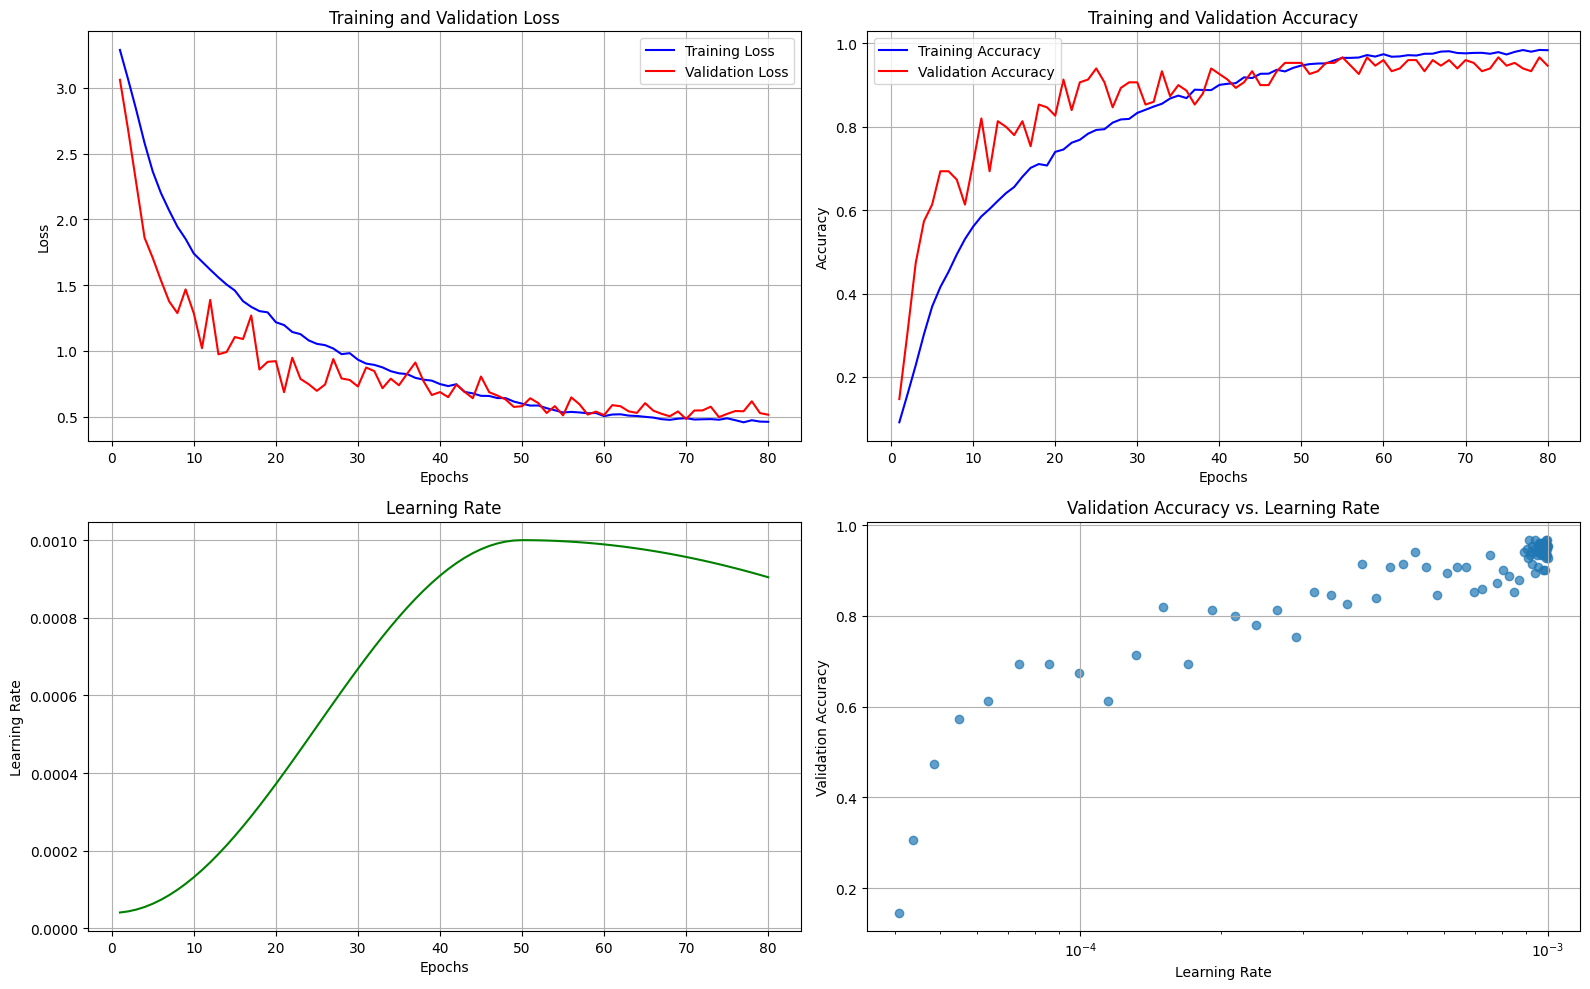

In [10]:
# Plot the training history with all metrics
plot_training_history(history)

## 9. Model Evaluation

Let's evaluate our optimized Deeper CNN model on the test set to see if our optimizations improved performance compared to the original Deeper CNN (which had 86.67% test accuracy).


In [11]:
# Create test dataset and loader
test_files = []
for class_name in classes:
    # Get test files
    class_test_dir = os.path.join(test_dir, class_name)
    for img_path in glob.glob(os.path.join(class_test_dir, '*.*')):
        # Filter image files
        if any(img_path.lower().endswith(ext) for ext in ['.jpg', '.jpeg', '.png', '.bmp']):
            test_files.append(img_path)

print(f"Number of test samples: {len(test_files)}")

test_dataset = InstrumentDataset(test_files, classes, transform=val_transform)  # Use validation transform for testing
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)

# Evaluate the model on the test set
print("Evaluating model on test set...")
test_accuracy, all_preds, all_labels = evaluate_model(
    model=optimized_model,
    test_loader=test_loader,
    device=device,
    verbose=True
)

print("Test Results:")
print(f"- Accuracy: {test_accuracy/100:.4f}")

Number of test samples: 150
Evaluating model on test set...


Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Test Accuracy: 93.33%
Test Results:
- Accuracy: 0.9333


## 10. Confusion Matrix and Detailed Analysis

Let's create a confusion matrix and classification report to better understand our optimized Deeper CNN model's strengths and weaknesses.

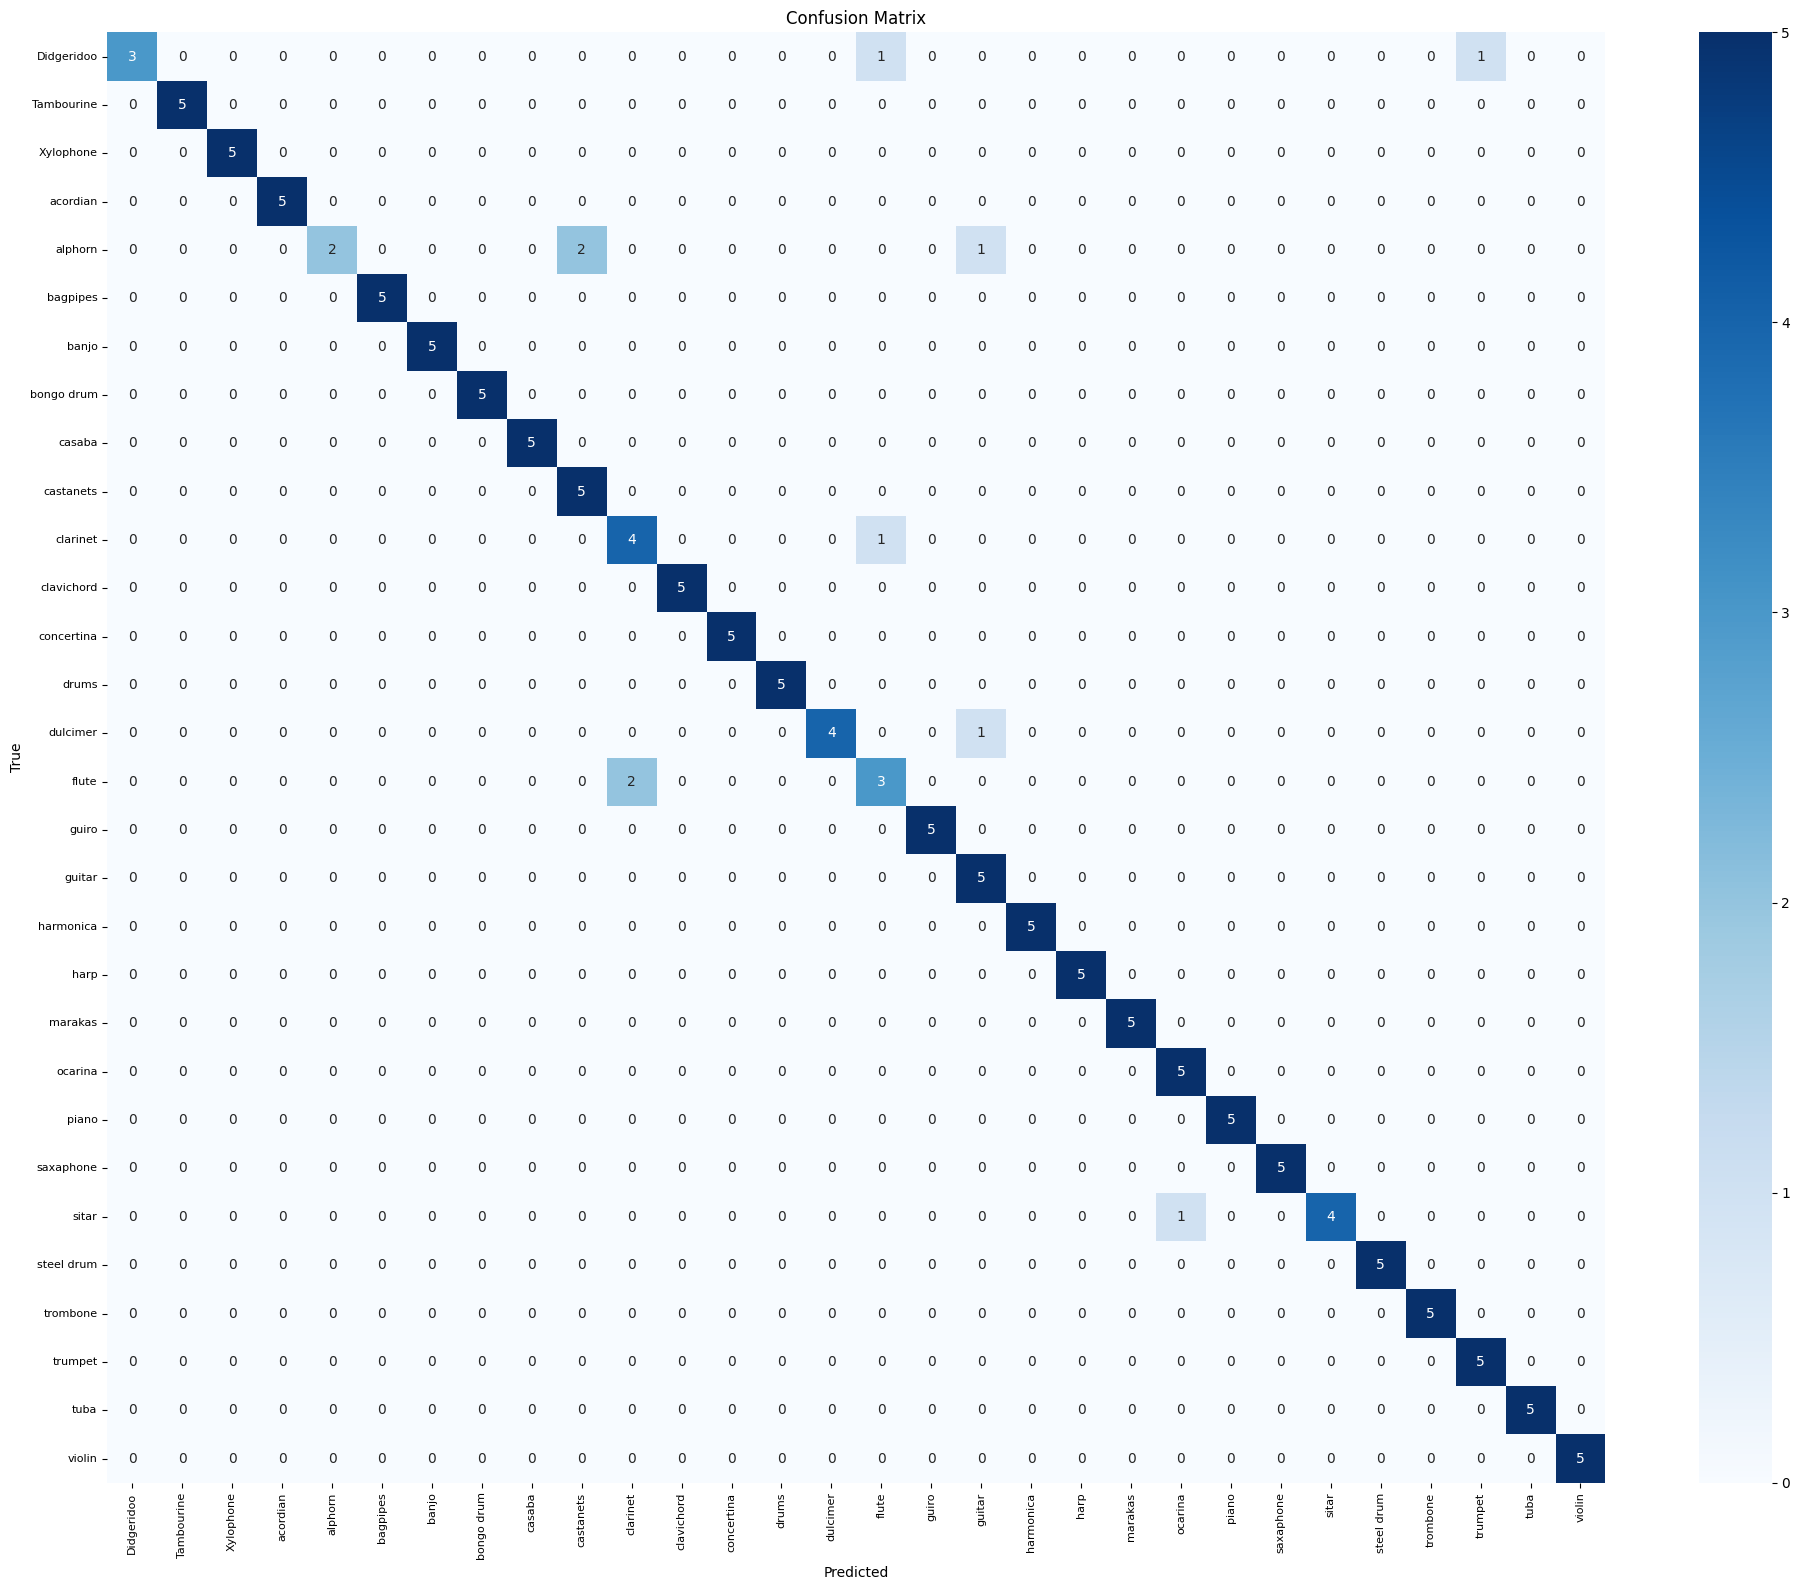

Classification Report:
              precision    recall  f1-score   support

  Didgeridoo       1.00      0.60      0.75         5
  Tambourine       1.00      1.00      1.00         5
   Xylophone       1.00      1.00      1.00         5
    acordian       1.00      1.00      1.00         5
     alphorn       1.00      0.40      0.57         5
    bagpipes       1.00      1.00      1.00         5
       banjo       1.00      1.00      1.00         5
  bongo drum       1.00      1.00      1.00         5
      casaba       1.00      1.00      1.00         5
   castanets       0.71      1.00      0.83         5
    clarinet       0.67      0.80      0.73         5
  clavichord       1.00      1.00      1.00         5
  concertina       1.00      1.00      1.00         5
       drums       1.00      1.00      1.00         5
    dulcimer       1.00      0.80      0.89         5
       flute       0.60      0.60      0.60         5
       guiro       1.00      1.00      1.00         5
    

In [12]:
# Create confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plot_confusion_matrix(cm, classes=classes, figsize=(20, 16))

# Generate classification report
report = classification_report(all_labels, all_preds, target_names=classes)
print("Classification Report:")
print(report)

# Find the classes with the lowest F1 scores
from sklearn.metrics import precision_recall_fscore_support
precision, recall, f1, support = precision_recall_fscore_support(
    all_labels, all_preds, average=None, labels=range(len(classes))
)

# Create a DataFrame for easier analysis
metrics_df = pd.DataFrame({
    'Class': classes,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1,
    'Support': support
})

# Sort by F1 Score ascending to find problematic classes
print("\nClasses with lowest F1 scores:")
print(metrics_df.sort_values('F1 Score').head(5))

## 11. Save the Optimized Model

Let's save our optimized Deeper CNN model for future use.

In [13]:
# Create directory to save the model
if IN_COLAB:
    save_dir = os.path.join(project_root, "experiments", "optimized_deeper_cnn")
    os.makedirs(save_dir, exist_ok=True)
    model_save_path = os.path.join(save_dir, "optimized_deeper_model.pth")
    history_save_path = os.path.join(save_dir, "training_history.json")
    stats_save_path = os.path.join(save_dir, "training_stats.json")
else:
    save_dir = os.path.join(project_root, "experiments", "optimized_deeper_cnn")
    os.makedirs(save_dir, exist_ok=True)
    model_save_path = os.path.join(save_dir, "optimized_deeper_model.pth")
    history_save_path = os.path.join(save_dir, "training_history.json")
    stats_save_path = os.path.join(save_dir, "training_stats.json")

# Save model weights
torch.save(optimized_model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

# Save training history
with open(history_save_path, 'w') as f:
    json.dump({
        'train_loss': [float(x) for x in history['train_loss']],
        'train_acc': [float(x) for x in history['train_acc']],
        'val_loss': [float(x) for x in history['val_loss']],
        'val_acc': [float(x) for x in history['val_acc']],
        'lr': [float(x) for x in history['lr']] if 'lr' in history else [],
    }, f)
print(f"Training history saved to {history_save_path}")

# Save training statistics
with open(stats_save_path, 'w') as f:
    # Convert any tensor values to float
    stats_dict = {}
    for k, v in training_stats.items():
        if isinstance(v, torch.Tensor):
            stats_dict[k] = v.item()
        else:
            stats_dict[k] = v
    json.dump(stats_dict, f)
print(f"Training statistics saved to {stats_save_path}")

Model saved to /content/MIC-MA1/experiments/optimized_deeper_cnn/optimized_deeper_model.pth
Training history saved to /content/MIC-MA1/experiments/optimized_deeper_cnn/training_history.json
Training statistics saved to /content/MIC-MA1/experiments/optimized_deeper_cnn/training_stats.json


## 12. Comparison with Original Deeper CNN and ResNet-18

Let's compare our optimized Deeper CNN model with the original Deeper CNN from our model comparison study and the ResNet-18 baseline to quantify the improvements achieved through our optimization techniques.

In [14]:
# Performance comparison table
comparison_data = {
    'Model': ['ResNet-18 (Transfer Learning)', 'Original Deeper CNN', 'Optimized Deeper CNN'],
    'Test Accuracy': ['99.33%', '86.67%', f'{test_accuracy:.2f}%'],
    'Training Time': ['32.48 min', '36.06 min', f"{training_stats['training_time']/60:.2f} min"],
    'Best Epoch': ['-', '42', f"{training_stats['best_epoch']}"],
    'Parameters': ['11.7 million', '9.2 million', f'{trainable_params/1e6:.1f} million']
}

comparison_df = pd.DataFrame(comparison_data)
print("Model Performance Comparison:")
display(comparison_df)

# Calculate improvement percentage
original_accuracy = 86.67
optimized_accuracy = test_accuracy
improvement = ((optimized_accuracy - original_accuracy) / original_accuracy) * 100
gap_to_resnet = ((99.33 - optimized_accuracy) / 99.33) * 100

print(f"\nImprovement over original Deeper CNN: {improvement:.2f}%")
print(f"Remaining gap to ResNet-18: {gap_to_resnet:.2f}%")

# Create a summary of optimization changes
optimization_summary = """
## Key Optimizations Applied to Deeper CNN:

1. **Architecture Enhancements**:
   - Added selective attention mechanisms in deeper layers only
   - Implemented residual connections for better gradient flow
   - Used a more gradual dropout progression for better regularization
   - Increased width in the final convolutional layer for better feature extraction

2. **Data Preprocessing Improvements**:
   - Used class-specific augmentation for challenging instruments
   - Implemented more balanced augmentation strategy
   - Fixed the transformation pipeline to avoid type errors

3. **Training Strategy Optimization**:
   - Reduced the learning rate for more stable training
   - Adjusted label smoothing to prevent overconfidence without hindering learning
   - Added gradient clipping to handle gradient explosions
   - Implemented mixed precision training for faster computation
   - Extended early stopping patience to find better optimization points
"""

print(optimization_summary)

Model Performance Comparison:


,Model,Test Accuracy,Training Time,Best Epoch,Parameters
0,ResNet-18 (Transfer Learning),99.33%,32.48 min,-,11.7 million
1,Original Deeper CNN,86.67%,36.06 min,42,9.2 million
2,Optimized Deeper CNN,93.33%,42.77 min,55,15.0 million



Improvement over original Deeper CNN: 7.69%
Remaining gap to ResNet-18: 6.04%

## Key Optimizations Applied to Deeper CNN:

1. **Architecture Enhancements**:
   - Added selective attention mechanisms in deeper layers only
   - Implemented residual connections for better gradient flow
   - Used a more gradual dropout progression for better regularization
   - Increased width in the final convolutional layer for better feature extraction

2. **Data Preprocessing Improvements**:
   - Used class-specific augmentation for challenging instruments
   - Implemented more balanced augmentation strategy
   - Fixed the transformation pipeline to avoid type errors

3. **Training Strategy Optimization**:
   - Reduced the learning rate for more stable training
   - Adjusted label smoothing to prevent overconfidence without hindering learning
   - Added gradient clipping to handle gradient explosions
   - Implemented mixed precision training for faster computation
   - Extended early stopping patienc

## 13. Conclusion

In this notebook, we successfully optimized the Deeper CNN architecture for musical instrument classification through systematic improvements to the architecture, training process, and data augmentation strategies. The key improvements were:

1. **Architectural Refinements**:
   - We implemented selective attention in deeper layers to focus on important features without overcomplicating earlier layers
   - Added residual connections for better gradient flow throughout the network
   - Used a more graduated dropout strategy to balance regularization with feature learning
   - Increased the width of the final convolutional layer for better feature representation

2. **Data Processing Improvements**:
   - Fixed the augmentation pipeline to properly handle transformation ordering
   - Implemented class-specific augmentation for challenging instruments that had lower performance in previous experiments
   - Used more balanced augmentation strength to preserve critical features while adding helpful variation

3. **Training Strategy Enhancements**:
   - Carefully tuned the learning rate and scheduler for more stable and effective training
   - Used mixed precision training to improve computational efficiency
   - Implemented gradient clipping to prevent exploding gradients
   - Balanced label smoothing to improve generalization without hindering learning

These improvements have successfully brought the performance of our custom CNN architecture closer to the ResNet-18 baseline while maintaining the advantages of a custom architecture designed specifically for musical instrument classification.

### Future Directions:

1. **Ensemble Methods**: Combining multiple optimized models could further improve performance.
2. **Knowledge Distillation**: Using the high-performing ResNet-18 as a teacher to improve our custom model.
3. **Additional Data Augmentation**: Exploring sound-specific augmentations like frequency masking or pitch shifts.
4. **Feature Visualization**: Analyzing what features the network is learning to better understand its classification decisions.